In [1]:
import pandas as pd

# Load metastable epialleles (comma-separated)
epialleles = pd.read_csv("/data/cephfs-1/work/groups/kühnen/users/cama15_c/metastable_epiallele_analysis/10_samples_work/metastable_epiallele_list.csv", sep=",", header=0)
epialleles = epialleles.drop(columns=["Hg19 data"])

In [2]:
# Add the two additional regions (make sure start < end)
additional = pd.DataFrame([
    {"Chr": "chr2", "Start": 25161685, "End": 25161767},
    {"Chr": "chr2", "Start": 113235385, "End": 113235510}
])

# Append them to the epiallele list
epialleles = pd.concat([epialleles, additional], ignore_index=True)

# Load combined methylation matrix
cpg_matrix = pd.read_csv("/data/cephfs-1/work/groups/kühnen/users/cama15_c/in_vivo_data/aligned_hg38_data/invivo_10_samples_meth_frac_only_matrix.csv", sep=",", header=0)

In [3]:
print(cpg_matrix.columns)

Index(['Chr', 'Start', 'End', 'ICM_Meth_frac', 'Liver_Meth_frac', 'Naive_mean',
       'Primed_mean', 'Primed_Neuron_mean', 'Formative_mean',
       'Formative_Neuron_mean'],
      dtype='object')


In [6]:
# Optional: Speed up by converting to categorical types
cpg_matrix["Chr"] = cpg_matrix["Chr"].astype("category")
epialleles["Chr"] = epialleles["Chr"].astype("category")

# Match CpGs within all metastable epialleles
matches = []
for _, row in epialleles.iterrows():
    chr_, start, end = row["Chr"], row["Start"], row["End"]
    subset = cpg_matrix[
        (cpg_matrix["Chr"] == chr_) &
        (cpg_matrix["Start"] >= start) &
        (cpg_matrix["End"] <= end)
    ]
    if not subset.empty:
        matches.append(subset)

# Concatenate all matches into one DataFrame
matched_cpgs = pd.concat(matches, ignore_index=True)

# Save to file
matched_cpgs.to_csv("inv_cpgs_within_metastable_epialleles.tsv", sep="\t", index=False)

In [7]:
print(matched_cpgs.columns)

Index(['Chr', 'Start', 'End', 'ICM_Meth_frac', 'Liver_Meth_frac', 'Naive_mean',
       'Primed_mean', 'Primed_Neuron_mean', 'Formative_mean',
       'Formative_Neuron_mean'],
      dtype='object')


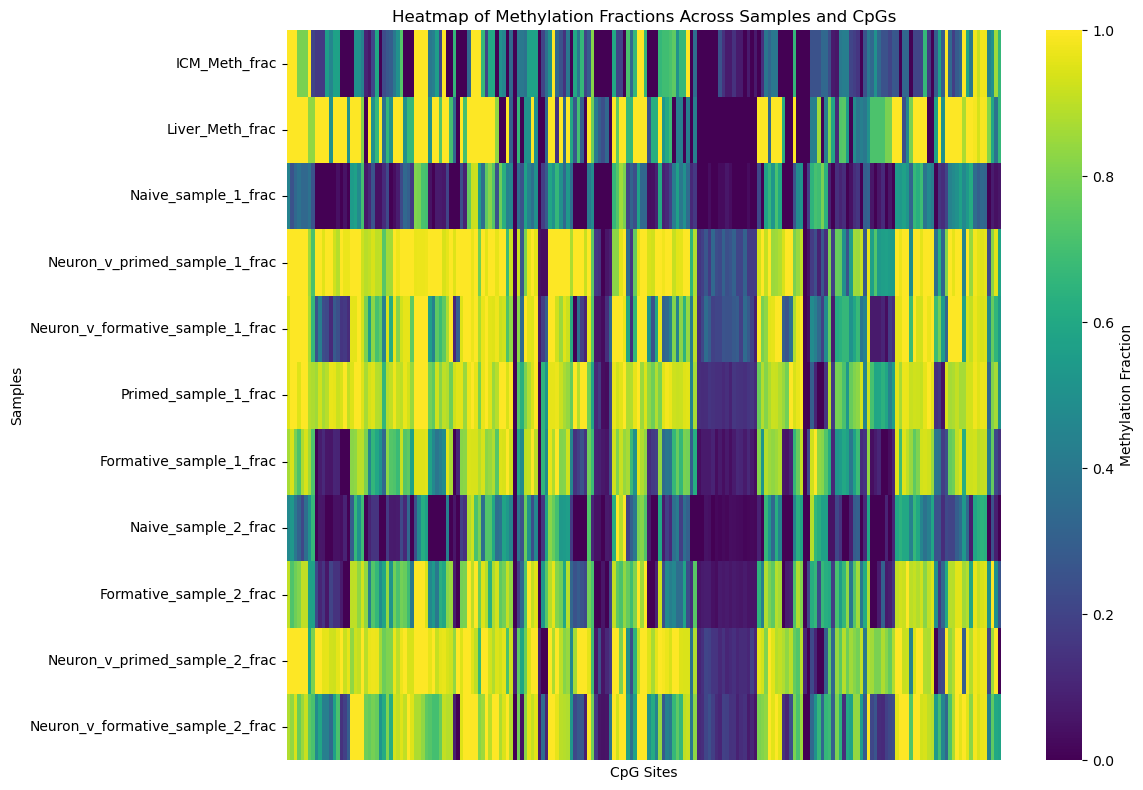

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select all _frac columns (methylation fractions)
frac_cols = [col for col in matched_cpgs.columns if col.endswith('_frac')]

# Optional: filter rows with sufficient coverage across samples (e.g., cov >= 5)
# For that, you need to find corresponding cov columns and filter accordingly
# Here is a simple filter for rows where all cov columns >= 5:

cov_cols = [col for col in matched_cpgs.columns if col.endswith('_cov')]

# Filter rows where all cov columns have coverage >= 5
coverage_filter = (matched_cpgs[cov_cols] >= 5).all(axis=1)
df_filtered = matched_cpgs[coverage_filter]

# Extract methylation fractions for filtered rows
meth_data = df_filtered[frac_cols]

# Optional: normalize rows or scale if needed (here, just raw fractions)

plt.figure(figsize=(12, 8))
sns.heatmap(
    meth_data.T,  # transpose so samples are rows and CpGs are columns
    cmap='viridis',
    cbar_kws={'label': 'Methylation Fraction'},
    xticklabels=False,
    yticklabels=True
)
plt.title("Heatmap of Methylation Fractions Across Samples and CpGs")
plt.xlabel("CpG Sites")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()
